In [1]:
import pandas as pd
import numpy as np
import pickle
import nltk
import re
import string
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import spacy
from collections import Counter
from sklearn.cluster import KMeans
import scipy.sparse as ss
from sklearn import datasets
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import pairwise_distances

In [2]:
# Read in the transcripts
with open('transcripts.pickle','rb') as read_file:
    transcripts = pickle.load(read_file)

"# Read in the transcripts\nwith open('transcripts.pickle','rb') as read_file:\n    transcripts = pickle.load(read_file)"

## Create df of 5mins of text/ row

In [3]:
def bin_5min_blocks(df, key):
    text_list = []
    time_list = []
    key_list = []
    i=0
    while i < len(df):
        current_time = df.start.iloc[i]
        current_text = ''
        while (i < len(df)) and (df.start.iloc[i] <= current_time+300):
            current_text = current_text + ' ' + df.text.iloc[i]
            i +=1
        time_list.append(current_time)
        text_list.append(current_text)
        key_list.append(key)
    return pd.DataFrame(list(zip(key_list, time_list, text_list)),\
                        columns=['episode', 'time','text'])

"def bin_5min_blocks(df, key):\n    text_list = []\n    time_list = []\n    key_list = []\n    i=0\n    while i < len(df):\n        current_time = df.start.iloc[i]\n        current_text = ''\n        while (i < len(df)) and (df.start.iloc[i] <= current_time+300):\n            current_text = current_text + ' ' + df.text.iloc[i]\n            i +=1\n        time_list.append(current_time)\n        text_list.append(current_text)\n        key_list.append(key)\n    return pd.DataFrame(list(zip(key_list, time_list, text_list)),                        columns=['episode', 'time','text'])"

In [4]:
binned_df = pd.DataFrame(columns=['episode','time','text'])
for key in transcripts.keys():
    binned_df = binned_df.append(bin_5min_blocks(pd.DataFrame(transcripts[key]), key))

"binned_df = pd.DataFrame(columns=['episode','time','text'])\nfor key in transcripts.keys():\n    binned_df = binned_df.append(bin_5min_blocks(pd.DataFrame(transcripts[key]), key))"

In [5]:
# Pickle the 5 min bin df
with open('binned_df.pickle', 'wb') as to_write:
    pickle.dump(binned_df, to_write)

"# Pickle the 5 min bin df\nwith open('binned_df.pickle', 'wb') as to_write:\n    pickle.dump(binned_df, to_write)"

# spaCy

In [6]:
# Read in the bin df
with open('binned_df.pickle','rb') as read_file:
    binned_df = pickle.load(read_file)

binned_df = binned_df.reset_index().drop(columns='index')

"# Read in the bin df\nwith open('binned_df.pickle','rb') as read_file:\n    binned_df = pickle.load(read_file)\n\nbinned_df = binned_df.reset_index().drop(columns='index')"

In [7]:
# Load spaCy's english core module

nlp = spacy.load('en_core_web_sm')

"# Load spaCy's english core module\n\nnlp = spacy.load('en_core_web_sm')"

### Tokenize

In [8]:
# Tokenization (takes 5-10 min to run)

binned_df['spacy_doc'] = list(nlp.pipe(binned_df.text))

# to tokenize one string:
# doc = nlp(text)

"# Tokenization (takes 5-10 min to run)\n\nbinned_df['spacy_doc'] = list(nlp.pipe(binned_df.text))\n\n# to tokenize one string:\n# doc = nlp(text)"

In [9]:
# Pickle the 5 min bin tokenized text (1.59 GB)
with open('token_5min_df.pickle', 'wb') as to_write:
    pickle.dump(binned_df, to_write)

"# Pickle the 5 min bin tokenized text (1.59 GB)\nwith open('token_5min_df.pickle', 'wb') as to_write:\n    pickle.dump(binned_df, to_write)"

In [10]:
# Read in the 5 min tokenized text
with open('token_5min_df.pickle','rb') as read_file:
    binned_df = pickle.load(read_file)

### Put Nouns and Adjectives in a string for each doc

In [11]:
def key_words(row):
    current_string = ''
    for token in row['spacy_doc']:
        if (token.is_stop == False) and ((token.pos_ == 'NOUN') or (token.pos_ == 'ADJ')):
            current_word = token.lemma_
            current_string = current_string + current_word + ' '
    return current_string

In [12]:
binned_df['key_words'] = binned_df.apply(key_words ,axis=1)

# Vectorize

In [13]:
vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df=0.3)
dtm = vectorizer.fit_transform(binned_df.key_words)

"vectorizer = CountVectorizer(strip_accents = 'unicode',\n                                stop_words = 'english',\n                                lowercase = True,\n                                token_pattern = r'\x08[a-zA-Z]{3,}\x08',\n                                max_df=0.3)\ndtm = vectorizer.fit_transform(binned_df.key_words)"

# Fit LDA Model

In [14]:
lda = LatentDirichletAllocation(n_components=16, random_state=0)
doc_topic_array = lda.fit_transform(dtm)

'lda = LatentDirichletAllocation(n_components=16, random_state=0)\ndoc_topic_array = lda.fit_transform(dtm)'

### Pickle Model, dtm and vectorizer

In [15]:
# Pickle the LDA Model, dtm, and vectorizer

mmv = [lda, dtm, vectorizer, doc_topic_array]

with open('mmv_5min.pickle', 'wb') as to_write:
    pickle.dump(mmv, to_write)

"# Pickle the LDA Model, dtm, and vectorizer\n\nmmv = [lda, dtm, vectorizer, doc_topic_array]\n\nwith open('mmv_5min.pickle', 'wb') as to_write:\n    pickle.dump(mmv, to_write)"

In [16]:
# Read in the LDA Model
with open('mmv_5min.pickle','rb') as read_file:
    mmv = pickle.load(read_file)

lda = mmv[0]
dtm = mmv[1]
vectorizer = mmv[2]
doc_topic_array = mmv[3]

# pyLDAvis

In [17]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, dtm, vectorizer, mds='mmds')

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.049489  0.096537       1        1  11.718838
4      0.056653  0.042013       2        1  11.386334
6     -0.013507  0.261311       3        1  11.223670
9      0.142905  0.197054       4        1   8.621766
7     -0.204217  0.209423       5        1   8.245150
12     0.053294 -0.260096       6        1   7.968779
0      0.050422  0.219747       7        1   7.722403
1      0.003453 -0.109530       8        1   7.353923
3     -0.302578  0.097065       9        1   6.913266
11     0.282869  0.109834      10        1   3.939080
15     0.123931 -0.091093      11        1   3.927340
13    -0.264628 -0.028599      12        1   3.056620
10     0.309462 -0.064245      13        1   2.298855
5     -0.250646 -0.171119      14        1   1.961786
14    -0.138515 -0.262489      15        1   1.861484
8      0.200591 -0.245812      16        1   1.800705, topic_info=            Term         Freq        Total Category  logprob  loglift
12489       tire  1013.000000  1013.000000  Default  30.0000  30.0000
12236       team  1750.000000  1750.000000  Default  29.0000  29.0000
7901      muscle  1827.000000  1827.000000  Default  28.0000  28.0000
12335       test   997.000000   997.000000  Default  27.0000  27.0000
12643    trainer  1405.000000  1405.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
13654      wheel    32.791024  1023.945485  Topic16  -5.3591   0.5757
11088  situation    31.015143   789.856057  Topic16  -5.4148   0.7796
8582        pace    28.744872   567.166475  Topic16  -5.4908   1.0348
6980        life    28.559141   750.976758  Topic16  -5.4973   0.7476
7606        mile    28.932040  1079.472789  Topic16  -5.4843   0.3977

[1164 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
45         3  0.712150  acceleration
45         4  0.173695  acceleration
45        10  0.112902  acceleration
52         1  0.024772        access
52         2  0.041286        access
...      ...       ...           ...
13891      6  0.089597       youtube
13891      8  0.689894       youtube
13891     11  0.017919       youtube
13918      6  0.958790        zipper
13921     15  0.808735        zombie

[5076 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 7, 10, 8, 13, 1, 2, 4, 12, 16, 14, 11, 6, 15, 9])

# Get top words for each topic

In [18]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
display_topics(lda, vectorizer.get_feature_names(), 16)


Topic  0
weight, strength, muscle, pound, fat, leg, fiber, strong, endurance, calorie, cyclist, type, watt, mass, gym, force

Topic  1
coach, thank, cycling, awesome, trainerroad, group, episode, live, trainer, video, cyclist, team, fun, new, forum, pro

Topic  2
plan, volume, recovery, stress, base, fitness, season, event, intensity, sweet, life, important, phase, month, rest, build

Topic  3
food, bottle, calorie, gram, carbohydrate, water, nutrition, fat, gel, station, carb, caffeine, protein, morning, aid, meal

Topic  4
mountain, climb, mile, cross, section, flat, trail, skill, track, technical, effort, group, speed, rider, stage, fun

Topic  5
test, ramp, collagen, breath, breathing, air, cold, allergy, mouth, nose, asthma, nitrate, interesting, meat, result, number

Topic  6
team, rider, group, field, line, lap, wheel, sprint, turn, breakaway, corner, crit, wind, speed, sprinter, attack

Topic  7
muscle, study, blood, cell, effect, performance, exercise, fat, endurance, brain, 

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Create doc_topic_df with labeled topics

In [20]:
# make weight readable
topic_list = ['strength','tr_chat','training_plan_structure','nutrition',\
              'mtb_racing','testing_medical','road_racing','physiology',\
              'interuptions','workout_structure','bike_mechanics','trainer_technical',\
              'riding_technical','heat_sweat','special_physical_cases','goals']
doc_topic = pd.DataFrame(doc_topic_array, columns = topic_list)
doc_topic_df = pd.concat([binned_df[['episode','time']], doc_topic], axis=1)

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# Change seconds to minutes

doc_topic_df['time'] = doc_topic_df['time']/60

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topics within Episodes

In [30]:
colors = ['red', 'darkorange', 'black', 'cyan', 'lightgreen', 'darkblue', 'lightblue', 'darkmagenta', 'magenta', 'saddlebrown',\
           'burlywood', 'lightgray', 'yellow', 'lightcoral', 'pink', 'olive']

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
cumulative_topics = doc_topic_df.copy()
for i in range(len(cumulative_topics.columns)):
    if i >= 3:
        cumulative_topics[cumulative_topics.columns[i]] = cumulative_topics.iloc[:,i] + cumulative_topics.iloc[:,i-1]

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


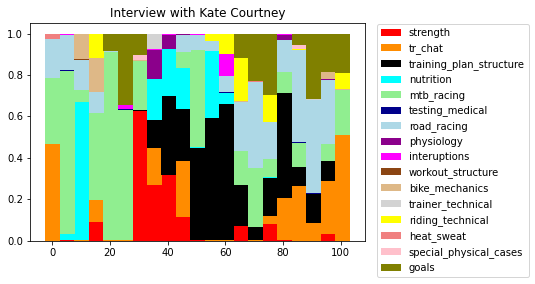

In [462]:

episode = 'FxkskxuBj1s'

colors = ['red', 'darkorange', 'black', 'cyan', 'lightgreen', 'darkblue', 'lightblue', 'darkmagenta',\
          'magenta', 'saddlebrown', 'burlywood', 'lightgray', 'yellow', 'lightcoral', 'pink', 'olive']

topic_list = ['strength','tr_chat','training_plan_structure','nutrition',\
              'mtb_racing','testing_medical','road_racing','physiology',\
              'interuptions','workout_structure','bike_mechanics','trainer_technical',\
              'riding_technical','heat_sweat','special_physical_cases','goals']

plt.bar(doc_topic_df[doc_topic_df['episode']==episode].time,\
        doc_topic_df[doc_topic_df['episode']==episode].strength,\
        width=5.1,color=colors[0], label=topic_list[0])

for i in range(3,18):
    plt.bar(doc_topic_df[doc_topic_df['episode']==episode].time,\
            doc_topic_df[doc_topic_df['episode']==episode].iloc[:,i],\
            bottom=cumulative_topics[cumulative_topics['episode']==episode].iloc[:,i-1],\
            width=5.1,\
            color=colors[i-2],\
            label = topic_list[i-2])
plt.legend(bbox_to_anchor=(1.02, 1.02))
plt.title('Interview with Kate Courtney');

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


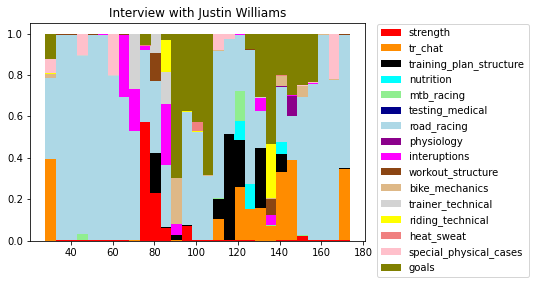

In [463]:
episode = '_oRkV7bkdxo'

colors = ['red', 'darkorange', 'black', 'cyan', 'lightgreen', 'darkblue', 'lightblue', 'darkmagenta',\
          'magenta', 'saddlebrown', 'burlywood', 'lightgray', 'yellow', 'lightcoral', 'pink', 'olive']

topic_list = ['strength','tr_chat','training_plan_structure','nutrition',\
              'mtb_racing','testing_medical','road_racing','physiology',\
              'interuptions','workout_structure','bike_mechanics','trainer_technical',\
              'riding_technical','heat_sweat','special_physical_cases','goals']

plt.bar(doc_topic_df[doc_topic_df['episode']==episode].time,\
        doc_topic_df[doc_topic_df['episode']==episode].strength,\
        width=5.1,color=colors[0], label=topic_list[0])

for i in range(3,18):
    plt.bar(doc_topic_df[doc_topic_df['episode']==episode].time,\
            doc_topic_df[doc_topic_df['episode']==episode].iloc[:,i],\
            bottom=cumulative_topics[cumulative_topics['episode']==episode].iloc[:,i-1],\
            width=5.1,\
            color=colors[i-2],\
            label = topic_list[i-2])
plt.legend(bbox_to_anchor=(1.02, 1.02))
plt.title('Interview with Justin Williams');

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


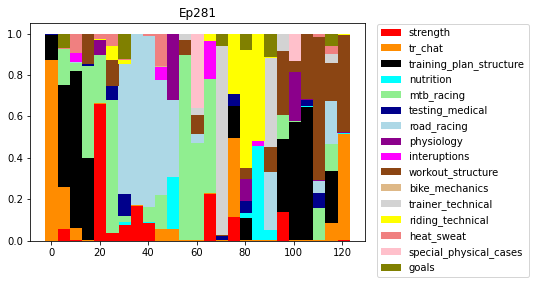

In [470]:
episode = 'iw7AKGGBwnQ'

colors = ['red', 'darkorange', 'black', 'cyan', 'lightgreen', 'darkblue', 'lightblue', 'darkmagenta',\
          'magenta', 'saddlebrown', 'burlywood', 'lightgray', 'yellow', 'lightcoral', 'pink', 'olive']

topic_list = ['strength','tr_chat','training_plan_structure','nutrition',\
              'mtb_racing','testing_medical','road_racing','physiology',\
              'interuptions','workout_structure','bike_mechanics','trainer_technical',\
              'riding_technical','heat_sweat','special_physical_cases','goals']

plt.bar(doc_topic_df[doc_topic_df['episode']==episode].time,\
        doc_topic_df[doc_topic_df['episode']==episode].strength,\
        width=5.1,color=colors[0], label=topic_list[0])

for i in range(3,18):
    plt.bar(doc_topic_df[doc_topic_df['episode']==episode].time,\
            doc_topic_df[doc_topic_df['episode']==episode].iloc[:,i],\
            bottom=cumulative_topics[cumulative_topics['episode']==episode].iloc[:,i-1],\
            width=5.1,\
            color=colors[i-2],\
            label = topic_list[i-2])
plt.legend(bbox_to_anchor=(1.02, 1.02))
plt.title('Ep281');

# Topics per Episodes

In [42]:
# Read in episode details
with open('episode_details.pickle','rb') as read_file:
    episode_details = pickle.load(read_file)

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
# Clean up the df that contains episode metadata
episodes_df = pd.DataFrame(episode_details).T
episodes_df['episode'] = episodes_df.index
episodes_df = episodes_df.reset_index()
episodes_df.drop(columns='index', inplace=True)
episodes_df['datetime'] = pd.to_datetime(episodes_df['date'])
episodes_df['dislikes'] = episodes_df['dislikes'].astype(int)
episodes_df['views'] = episodes_df['views'].str.replace(',','').astype(int)

def replace_K(row):
    if 'K' in row['likes']:
        val = row['likes'].replace('K','')
        val = float(val)
        val = val*1000
        return val
    else:
        return int(row['likes'])

episodes_df['likes'] = episodes_df.apply(replace_K, axis=1)

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
# Get mean topic score per episode

ep_topic_df = doc_topic_df.groupby(['episode']).mean()
ep_topic_df = ep_topic_df.drop(columns='time')

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
# Sort episodes by date

episodes_df = episodes_df.sort_values(by = 'datetime').reset_index()
episodes_df.drop(columns='index',inplace=True)

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
# drop episodes if the transript isn't available

episodes_df = episodes_df[episodes_df['episode'].isin(ep_topic_df.index)]
episodes_df = episodes_df.reset_index()
episodes_df = episodes_df.drop(columns='index')

/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/Jay/opt/anaconda3/envs/metis/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


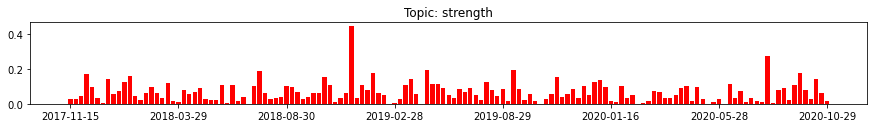

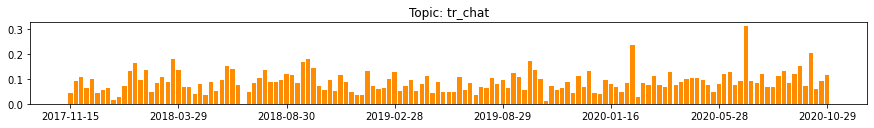

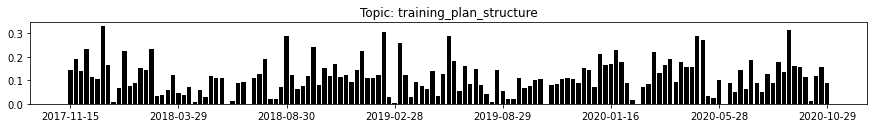

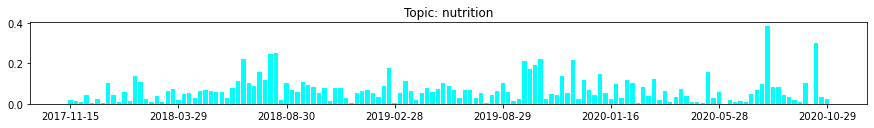

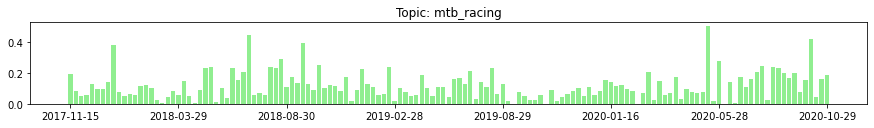

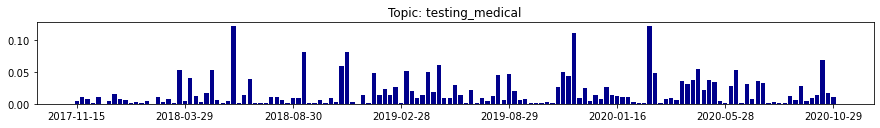

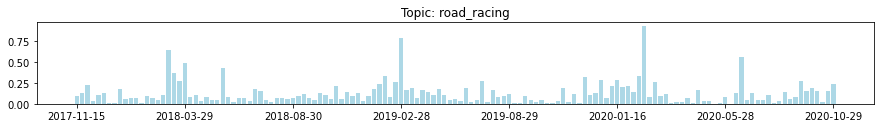

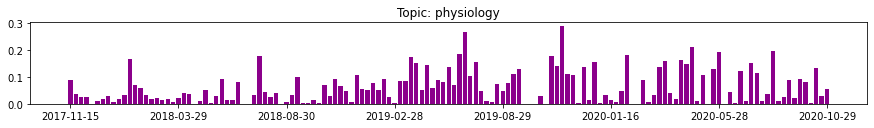

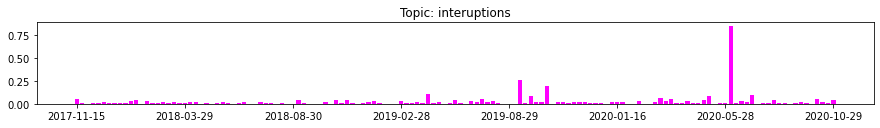

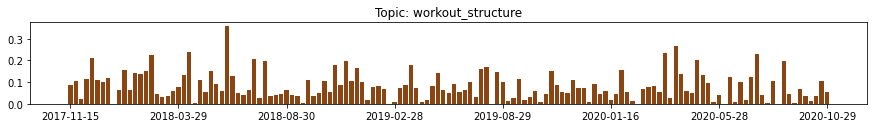

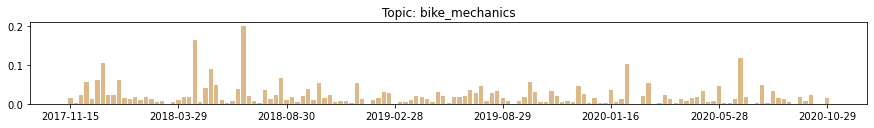

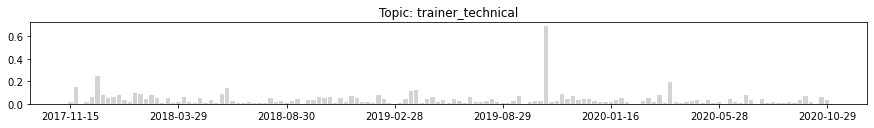

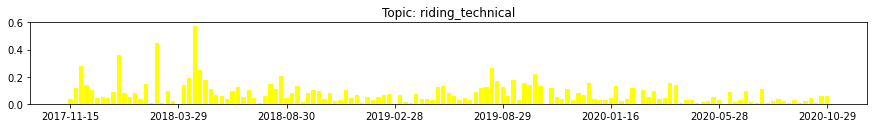

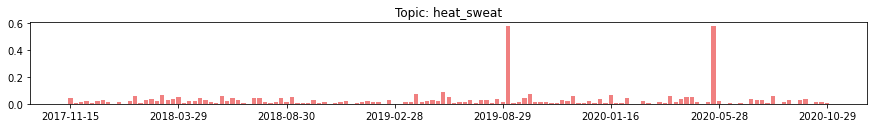

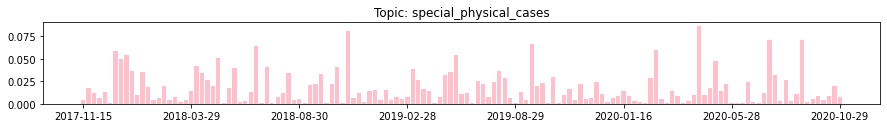

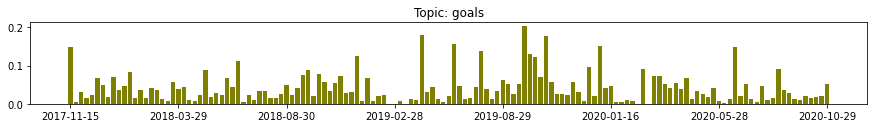

In [66]:
dates = []
for i in np.arange(0,141,20):
    dates.append(episodes_df.date[i])

for i in range(len(topic_list)):
    plt.figure(figsize=[15,1.5])
    colors = ['red', 'darkorange', 'black', 'cyan', 'lightgreen', 'darkblue', 'lightblue', 'darkmagenta',\
              'magenta', 'saddlebrown', 'burlywood', 'lightgray', 'yellow', 'lightcoral', 'pink', 'olive']

    topic_list = ['strength','tr_chat','training_plan_structure','nutrition',\
                  'mtb_racing','testing_medical','road_racing','physiology',\
                  'interuptions','workout_structure','bike_mechanics','trainer_technical',\
                  'riding_technical','heat_sweat','special_physical_cases','goals']

    for episode in episodes_df.episode:
        plt.bar(episodes_df[episodes_df['episode'] == episode].index,
                ep_topic_df.loc[episode,topic_list[i]],
                color=colors[i])
    plt.xticks(np.arange(0,141,20), dates)
    plt.title('Topic: {}'.format(topic_list[i]));